In [1]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio.v2 as imageio
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import glob
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense


c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\herna\anaconda3\envs\SpectroCNN\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

# Config GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Importing data

In [6]:
# mport train
df_train = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

## Standarizing data


In [7]:
df_train.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,303,0,0,0,0,0,0.0,0,0,0,0,0
1,304,0,6,0,0,1,1.0,2,2,0,0,0
2,305,0,7,1,0,1,1.0,2,2,1,0,0
3,310,0,4,1,1,1,0.0,0,0,1,1,0
4,312,0,2,1,0,0,1.0,1,0,0,0,0


In [8]:
df_test_full.head()

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
0,300,0,2,1
1,301,0,3,1
2,306,0,0,0
3,308,1,22,0
4,309,1,15,1


In [9]:
df_test_full['PHQ8_Score'] = df_test_full['PHQ_Score']
df_test_full.drop('PHQ_Binary', axis=1, inplace=True)

In [10]:
df_test_full.head(1)

,Participant_ID,PHQ_Score,Gender,PHQ8_Score
0,300,2,1,2


In [11]:
df_train.head(1)

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,303,0,0,0,0,0,0.0,0,0,0,0,0


In [12]:
df_dev.head(1)

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0


In [13]:
df_complete = pd.concat([df_test_full, df_dev, df_train], axis=0)

In [14]:
df_complete.head()

,Participant_ID,PHQ_Score,Gender,PHQ8_Score,PHQ8_Binary,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,300,2.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,301,3.0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,306,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,308,22.0,0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,309,15.0,1,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(f'df_train: {df_train.shape[0]} rows\n'
      f'df_test_full: {df_test_full.shape[0]} rows\n'
      f'df_dev: {df_dev.shape[0]} rows\n'
      f'Total: {df_train.shape[0] + df_test_full.shape[0] + df_dev.shape[0]} rows \n\n'
      
      f'df_complete: {df_complete.shape[0]} rows\n'
      f'df_test: {df_test.shape[0] + df_test.shape[0] + df_test.shape[0]} rows (DISCARD)\n')
      


df_train: 107 rows
df_test_full: 47 rows
df_dev: 35 rows
Total: 189 rows 

df_complete: 189 rows
df_test: 141 rows (DISCARD)



## Visualizing distribution

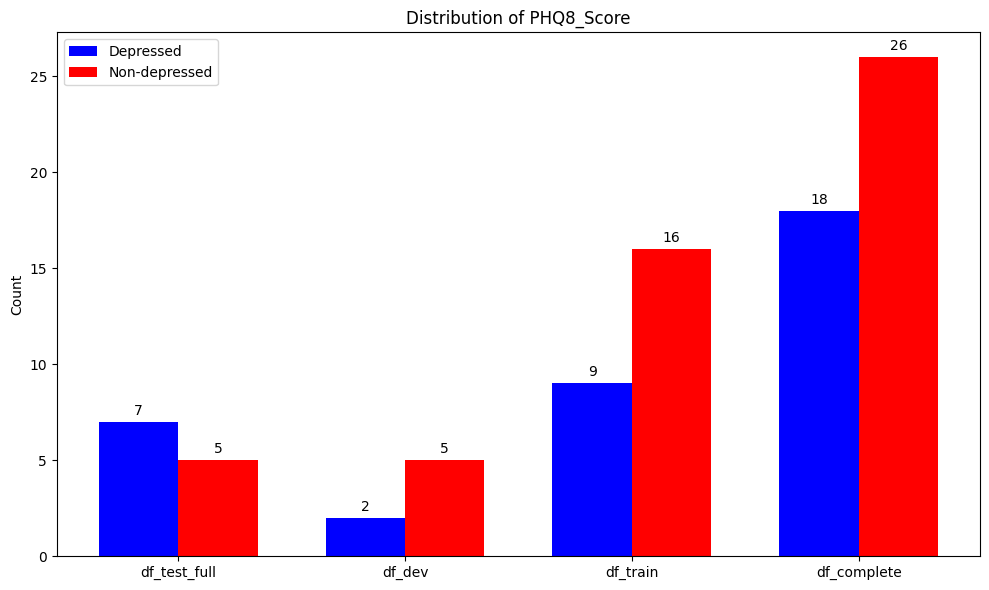

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_phq8_distribution_shared_cases(df_list, titles, labels):
    true_counts = []
    false_counts = []

    for df in df_list:
        true_count = df[df['PHQ8_Score'] == 1].shape[0]
        false_count = df[df['PHQ8_Score'] == 0].shape[0]
        true_counts.append(true_count)
        false_counts.append(false_count)
    
    x = np.arange(len(df_list))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, true_counts, width, label=labels[0], color='blue')
    rects2 = ax.bar(x + width/2, false_counts, width, label=labels[1], color='red')

    ax.set_ylabel('Count')
    ax.set_title('Distribution of PHQ8_Score')
    ax.set_xticks(x)
    ax.set_xticklabels(titles)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Example usage:
plot_phq8_distribution_shared_cases([df_test_full, df_dev, df_train, df_complete], ['df_test_full', 'df_dev', 'df_train', 'df_complete'], ['Depressed', 'Non-depressed'])


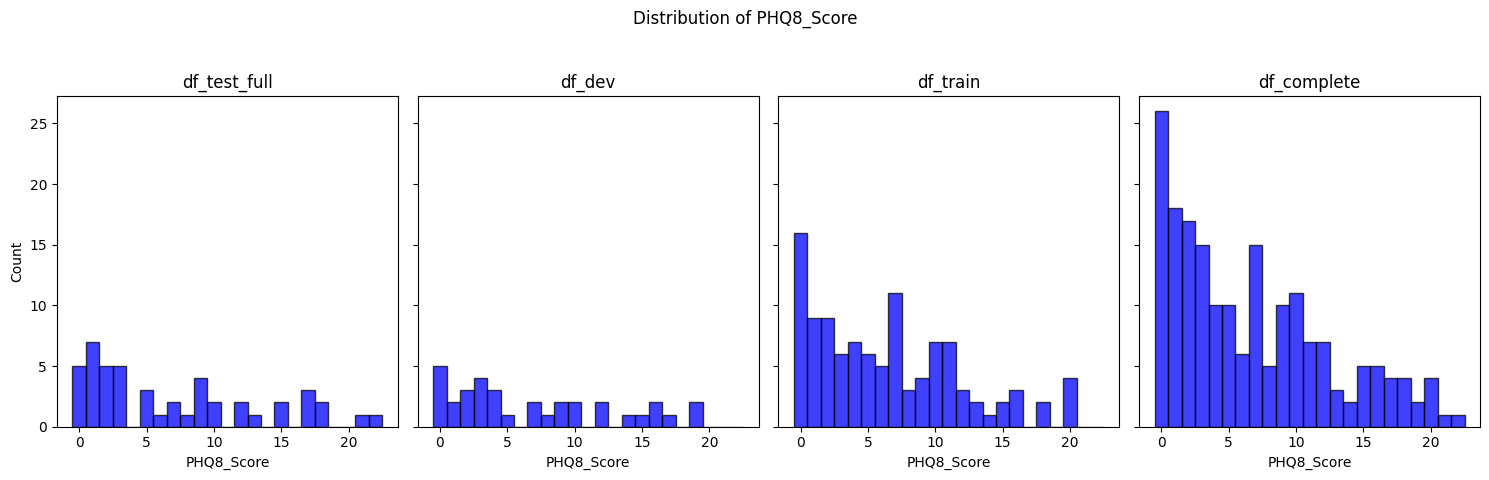

In [17]:
def plot_phq8_distribution_shared(df_list, titles, labels):
    fig, axs = plt.subplots(1, len(df_list), figsize=(15, 5), sharey=True)
    fig.suptitle('Distribution of PHQ8_Score')

    for i, (df, title) in enumerate(zip(df_list, titles)):
        axs[i].hist(df['PHQ8_Score'].dropna(), bins=np.arange(-0.5, 23.5, 1), alpha=0.75, color='blue', edgecolor='black')
        axs[i].set_title(title)
        axs[i].set_xlabel('PHQ8_Score')
        axs[i].set_ylabel('Count' if i == 0 else '')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
plot_phq8_distribution_shared([df_test_full, df_dev, df_train, df_complete], ['df_test_full', 'df_dev', 'df_train', 'df_complete'], ['Depressed', 'Non-depressed'])

In [18]:
def plot_phq8_distribution_by_gender(df, title):
    genders = df['Gender'].unique()
    fig, ax = plt.subplots(figsize=(10, 6))
    for gender in genders:
        subset = df[df['Gender'] == gender]
        ax.hist(subset['PHQ8_Score'].dropna(), bins=np.arange(-0.5, 23.5, 1), alpha=0.5, label=f'Gender {gender}', edgecolor='black')
    
    ax.set_title(title)
    ax.set_xlabel('PHQ8_Score')
    ax.set_ylabel('Count')
    ax.legend(title='Gender')
    plt.show()
    


# Balancing datasets (complete)

In [19]:
def balance_data(df, target_column, test_size=0.2, random_state=None):
    """
    Balance the data by creating a train-test split with equal representation of each class.
    
    Args:
    - df (DataFrame): The original DataFrame.
    - target_column (str): The name of the target column.
    - test_size (float): The proportion of the data to include in the test split.
    - random_state (int or None): Random seed for reproducibility.
    
    Returns:
    - train_df (DataFrame): The balanced training DataFrame.
    - test_df (DataFrame): The balanced testing DataFrame.
    """
    # Separate data into positive and negative classes
    positive_data = df[df[target_column] == 1]
    negative_data = df[df[target_column] == 0]
    
    # Determine the number of samples in each class for train and test sets
    train_size = int(min(len(positive_data), len(negative_data)) * (1 - test_size))
    test_positive_samples = int(len(positive_data) * test_size)
    test_negative_samples = int(len(negative_data) * test_size)
    
    # Randomly sample from each class for test set
    test_positive = positive_data.sample(n=test_positive_samples, random_state=random_state)
    test_negative = negative_data.sample(n=test_negative_samples, random_state=random_state)
    
    # Sample from the larger class with replacement to match the size of the smaller class
    if len(positive_data) > len(negative_data):
        train_positive = positive_data.sample(n=train_size, replace=True, random_state=random_state)
        train_negative = negative_data.sample(n=train_size, random_state=random_state)
    else:
        train_positive = positive_data.sample(n=train_size, random_state=random_state)
        train_negative = negative_data.sample(n=train_size, replace=True, random_state=random_state)
    
    # Concatenate positive and negative samples for train and test sets
    train_df = pd.concat([train_positive, train_negative], ignore_index=True)
    test_df = pd.concat([test_positive, test_negative], ignore_index=True)
    

    
    return train_df, test_df


In [20]:
df_complete

,Participant_ID,PHQ_Score,Gender,PHQ8_Score,PHQ8_Binary,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,300,2.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,301,3.0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,306,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,308,22.0,0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,309,15.0,1,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,485,NaN,1,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
103,486,NaN,0,4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
104,487,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,488,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


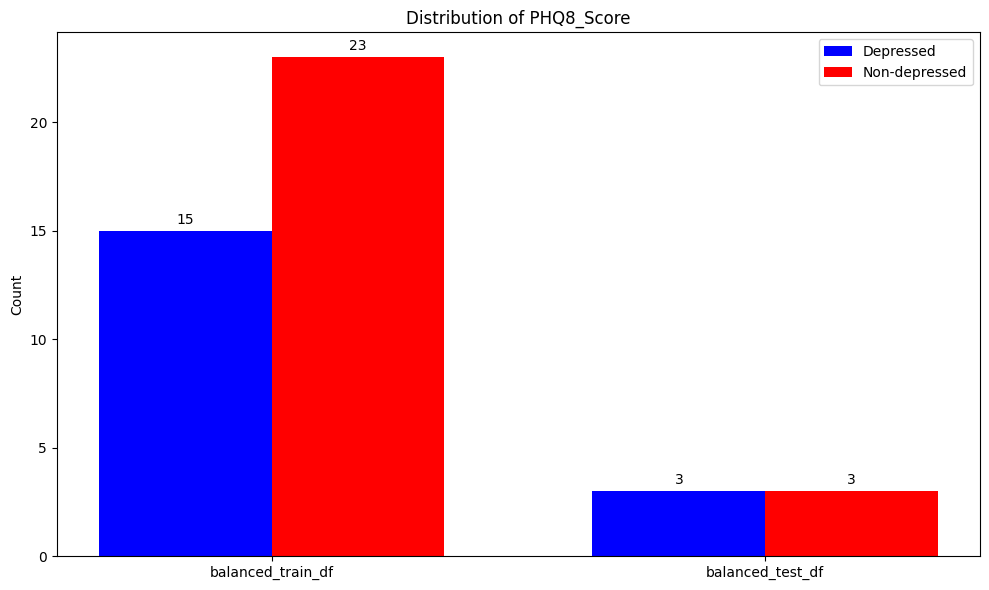

In [21]:
# Example usage:
train_df, test_df = train_test_split(df_complete, test_size=0.2, random_state=1)
plot_phq8_distribution_shared_cases([train_df, test_df], ['balanced_train_df', 'balanced_test_df'], ['Depressed', 'Non-depressed'])

In [22]:
print(train_df.shape)
print(test_df.shape)

(151, 13)
(38, 13)


# Loading spectrograns

In [23]:
def load_spectrogram(df):
    # Define root path of data
    root_path = 'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data'  # Replace with your root path

    # Add the column for spectrogram if it doesn't exist
    if 'Spectrogram' not in df.columns:
        # Define the shape of the fixed tensor
        tensor_shape = (292, 252, 3)  # Example shape (height, width, channels)

        # Create a fixed tensor of zeros with the desired shape
        fixed_tensor = np.zeros(tensor_shape, dtype=np.uint8)  # Adjust dtype as needed

        # Initialize the 'Spectrogram' column with the fixed tensor
        df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]

    # Handle missing values in 'Participant_ID' column
    df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')

    # Create an empty list to store modified rows
    modified_rows = []
    for index, row in df.iterrows():
            if not pd.isnull(row['Participant_ID']):  # Check if Participant_ID is not NaN
                participant_id = str(int(row['Participant_ID']))
                folder_path = os.path.join(root_path, str(participant_id) + '_P/resized')
                if os.path.isdir(folder_path):
                    # Flag to check if the first spectrogram has been loaded
                    first_loaded = False
                    # Iterate over image files in the folder
                    for image_file in glob.glob(os.path.join(folder_path, '*.jpg')):
                        image_path = os.path.join(folder_path, image_file)
                        if os.path.isfile(image_path):
                            # If it's the first spectrogram, add it to the original row
                            if not first_loaded:
                                image = imageio.imread(image_path)
                                row['Spectrogram'] = image
                                modified_rows.append(row)  # Add the modified row to the list
                                first_loaded = True
                            else:
                                # Create a copy of the original row
                                new_row = row.copy()
                                # Load the new image
                                new_image = imageio.imread(image_path)
                                # Assign the new image to the 'Spectrogram' column of the new row
                                new_row['Spectrogram'] = new_image
                                # Append the new row to the list
                                modified_rows.append(new_row)
                        else:
                            print(f"Image file not found at path {image_path}. Skipping...")
                else:
                    print(f"Folder not found at path {folder_path}. Skipping...")
                    raise Exception
    # Concatenate the original DataFrame with the modified rows
    #modified_df = pd.concat([df] + modified_rows, ignore_index=True)
    modified_df = pd.DataFrame(modified_rows)
    return modified_df
    #return df


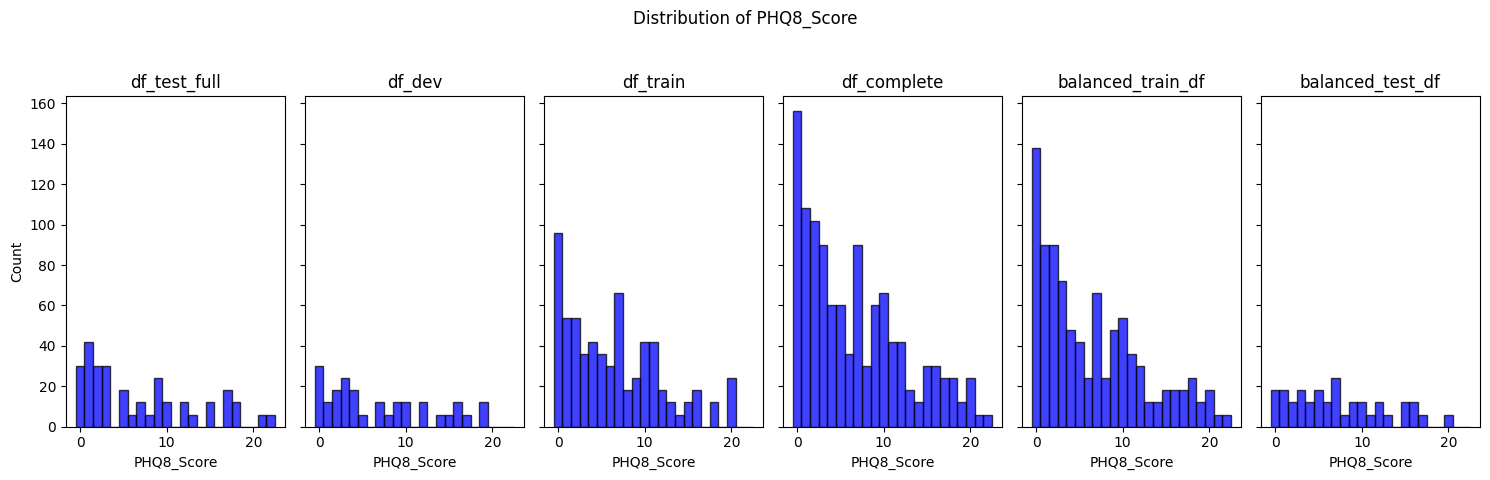

In [24]:
# Load df_test spectrograms
df_test_full = load_spectrogram(df_test_full)
df_dev = load_spectrogram(df_dev)
df_train = load_spectrogram(df_train)
df_complete = load_spectrogram(df_complete)
train_df = load_spectrogram(train_df)
test_df = load_spectrogram(test_df)
plot_phq8_distribution_shared([df_test_full, df_dev, df_train, df_complete, train_df, test_df], ['df_test_full', 'df_dev', 'df_train', 'df_complete', 'balanced_train_df', 'balanced_test_df'], ['Depressed', 'Non-depressed'])
      


# Verifying dataset and convertng to X and y 

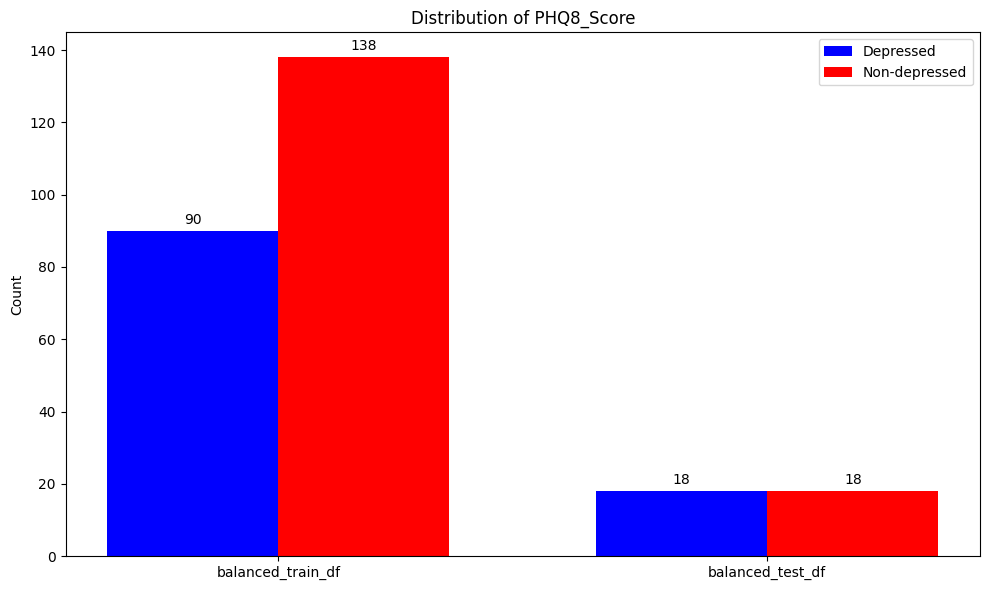

In [25]:
plot_phq8_distribution_shared_cases([train_df, test_df], ['balanced_train_df', 'balanced_test_df'], ['Depressed', 'Non-depressed'])

In [26]:
X_train = np.array(train_df['Spectrogram'].tolist())
y_train = train_df['PHQ8_Score'].values

X_test = np.array(test_df['Spectrogram'].tolist())
y_test = test_df['PHQ8_Score'].values

# Training the model

In [ ]:
# Hiperparameters
batch_size = 4
no_epochs = 100
verbosity = 1#2  # 1

# for train, test in kfold.split(X_train, y_train):
# Define the model architecture
model = Sequential()
# Convolutional block 1
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 2
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 3
model.add(BatchNormalization())
model.add(Conv2D(4, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 4
model.add(BatchNormalization())
model.add(Conv2D(4, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))

model.add(Flatten())

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision()])

# Generate a print
print('------------------------------------------------------------------------')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            min_delta=0.0001)

# Fit data to model
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbosity,
                    callbacks=[callback])





## Sigmoide

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, Adadelta
import tensorflow as tf
# Hiperparameters
batch_size = 4
no_epochs = 100
verbosity = 1#2  # 1
input_shape = (252,792,3)

# for train, test in kfold.split(X_train, y_train):
# Define the model architecture
model = Sequential()
model.add(BatchNormalization(input_shape=(input_shape)))  # Especifica input_shape
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adadelta(learning_rate=0.001), 
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision()])

# Generate a print
print('------------------------------------------------------------------------')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            min_delta=0.0001)


history = model.fit(X_train,
    y_train, 
    batch_size=batch_size, 
    epochs=no_epochs, 
    verbose=verbosity, 
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
            ])





# Linear

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

batch_size=10
input_shape = (252, 792, 3)
no_epochs = 100
verbosity = 1

model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
    
model.add(Dense(1, activation='linear'))  # Para regresión lineal, usar activación 'linear'

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mean_squared_error',  # Función de pérdida para regresión
              metrics=['mean_absolute_error'])  # Métrica adicional para regresión

# Ajustar el modelo en los datos de entrenamiento aumentados
model.fit(X_train,
          y_train, 
          batch_size=batch_size, 
          epochs=no_epochs, 
          verbose=verbosity, 
          validation_split=0.2,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
              tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
          ])


Epoch 1/100
73/73 [==============================] - 28s 376ms/step - loss: 88352.6484 - mean_absolute_error: 59.9158 - val_loss: 45.4166 - val_mean_absolute_error: 5.0308 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 25s 342ms/step - loss: 46.2019 - mean_absolute_error: 5.1155 - val_loss: 31.7098 - val_mean_absolute_error: 4.2192 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 24s 335ms/step - loss: 39.8424 - mean_absolute_error: 5.0594 - val_loss: 25.0641 - val_mean_absolute_error: 3.9887 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 24s 327ms/step - loss: 37.9902 - mean_absolute_error: 5.0182 - val_loss: 23.1398 - val_mean_absolute_error: 4.0045 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 24s 323ms/step - loss: 37.6627 - mean_absolute_error: 5.0395 - val_loss: 22.6654 - val_mean_absolute_error: 4.0526 - lr: 0.0010
Epoch 6/100
73/73 [==============================] - 24s 334ms/step - loss: 36.6844 - mean_

# Metrics

In [52]:
X_train.shape

(906, 252, 792, 3)

In [53]:
X_test.shape

(228, 252, 792, 3)

In [54]:
y_pred = model.predict(X_test).flatten()
y_pred

8/8 [==============================] - 2s 140ms/step


array([4.4966073, 5.155977 , 4.614552 , 6.4427285, 6.2956142, 6.013234 ,
       4.9178905, 5.1650524, 4.950615 , 5.920635 , 5.707976 , 5.4723268,
       5.08138  , 5.510538 , 5.065412 , 6.8080583, 6.6968274, 6.330536 ,
       4.8882737, 5.07346  , 4.7961044, 5.3807406, 5.370673 , 5.098581 ,
       5.0638337, 5.5365925, 5.024799 , 7.285685 , 6.920994 , 6.6636376,
       5.506754 , 5.525965 , 5.296475 , 5.7653465, 5.710023 , 5.4266343,
       4.4806867, 5.099444 , 4.6448326, 6.8854976, 6.6869583, 6.379584 ,
       5.2779713, 5.6341805, 5.298559 , 7.046078 , 6.840739 , 6.618614 ,
       4.7613373, 5.0060983, 4.701949 , 6.327964 , 6.287274 , 6.0138326,
       4.3905463, 4.7665496, 4.3787503, 6.4552894, 6.300442 , 6.149724 ,
       5.494844 , 5.6750655, 5.3070927, 7.0376954, 6.8411875, 6.6143355,
       4.1752753, 4.794947 , 4.1808214, 6.811755 , 6.5946574, 6.32237  ,
       4.8182874, 5.1012383, 4.8732   , 6.6710563, 6.525541 , 6.342474 ,
       4.3387566, 5.2972455, 4.6634927, 7.200907 , 

In [55]:
y_pred.shape

(228,)

In [56]:
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)
#y_pred_binary

8/8 [==============================] - 1s 124ms/step


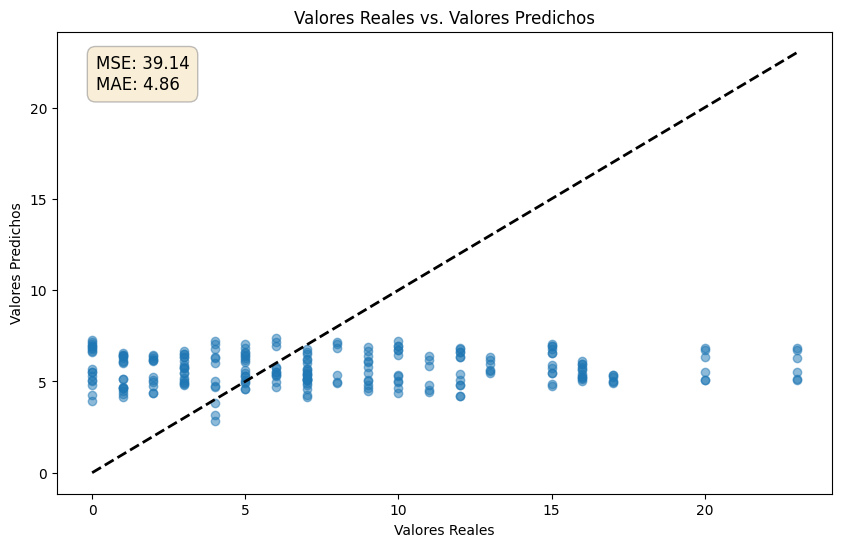

In [57]:
import matplotlib.pyplot as plt

# Evaluar el modelo en los datos de prueba
scores = model.evaluate(X_test, y_test, verbose=0)

# Predecir valores
y_pred = model.predict(X_test).flatten()

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs. Valores Predichos')
plt.text(0.05, 0.95, f'MSE: {scores[0]:.2f}\nMAE: {scores[1]:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='wheat', alpha=0.5))
plt.show()


In [60]:
scores

[39.137939453125, 4.855559825897217]

In [59]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Evaluate the model on test data
scores = model.evaluate(X_test, y_test, verbose=0)

# Predict probabilities
y_pred_prob = model.predict(X_test)
# Predict binary outcomes
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
specificity = tn / (tn + fp)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else float('nan')

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)

print(f'Mean Specificity: {specificity}')
print(f'Mean Recall: {recall}')
print(f'Mean F1 Score: {f1}')
print(f'Mean Accuracy: {scores[1] * 100}')
print(f'Mean Loss: {scores[0]}')
print(f'Mean Precision: {precision}')
print(f'Mean AUC: {auc}')
print()
print(f'True negatives: {tn}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')
print(f'False positives: {fp}')


8/8 [==============================] - 1s 123ms/step


ValueError: too many values to unpack (expected 4)

In [ ]:
folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/70-30_complete_cleaned_adam_arq_original/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Escribir valores medios en el archivo scores.txt
with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
    file.write(f'Mean Specificity: {specificity}\n')
    file.write(f'Mean Recall: {recall}\n')
    file.write(f'Mean F1 Score: {f1}\n')
    file.write(f'Mean Accuracy: {scores[1] * 100}\n')
    file.write(f'Mean Loss: {scores[0]}\n')
    file.write(f'Mean Precision: {precision}\n')
    file.write(f'Mean AUC: {auc}\n')
    file.write(f'True negatives: {tn}\n')
    file.write(f'False negatives: {fn}\n')
    file.write(f'True positives: {tp}\n')
    file.write(f'False positives: {fp}\n')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(folder_path, "confusion_matrix.jpg"))
plt.close()

# Graficar otras métricas
metrics = ['Specificity', 'Recall', 'F1 Score', 'Accuracy', 'Loss', 'Precision', 'AUC']
values = [specificity, recall, f1, scores[1], scores[0], precision, auc]
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.title("Model Metrics")
plt.ylabel("Value")
plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
plt.close()